In [0]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1
import warnings
warnings.filterwarnings('ignore')

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc0'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import os
import pathlib
import pandas as pd
from PIL import Image
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [0]:
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data

In [6]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [7]:
import pathlib
data_root = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/')
# data_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/')
data_source = pathlib.Path('/content/gdrive/My Drive/data/')
data_cleaned_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/')
data_train_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train')
data_val_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation')
print(data_root)
print(data_train_path)
print(data_val_path)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation


### Utils functions

In [0]:
# This function will get all image paths and file size
def get_file_size_from_path(path):
  labels = [x.name for x in path.glob('*') if x.is_dir() and x.name.endswith('0')]
  label_names = {key:value for value, key in enumerate(sorted(labels))}
  
  all_images = [str(x) for x in path.glob('*/*') if x.parent.name in label_names]

  results = []
  for image in all_images:
    fsize = os.path.getsize(image)
    results.append([image, fsize])
  
  return results

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
  
def preprocess_images(path_src, path_dest, verbose=0):
  """
  This function will preprocess all images inside source folder and copy to destination folder
  Parameters:
  - verbose: print out the progress. 0 or 1.
  - path_src: the path of source folder.
  - path_dest: the path of destination folder.
  """
  
  all_images_for_resizing = [str(x) for x in path_src.glob('*/*') if x.parent.name in label_names and x.is_file()]

  for image_path in all_images_for_resizing:

    image = Image.open(image_path)

    # check if image is PNG
    if len(image.split()) > 3:
      #convert PNG to JPEG
      image = image.convert('RGB')

    # check destination folders
    if not path_dest.is_dir():
      # destination train folder is not existed, create one
      os.mkdir(path_dest)

    # get the file name
    image_splits = image_path.rsplit('/', 2)
    dest_folder = pathlib.Path(os.path.join(path_dest, image_splits[1]))

    # if destination label folder not existed, then create one
    if not dest_folder.is_dir():
      os.mkdir(dest_folder)

    # set destination file name
    dest_filename = pathlib.Path(os.path.join(image_path.rsplit('/', 2)[-2], image_path.rsplit('/', 2)[-1]))
    # set new destination
    dest_filename = pathlib.Path(os.path.join(path_dest, dest_filename))

    # image resizing process
    if image.width > 500 or image.height > 500:
      # set the new dimensions
      if (image.width > image.height): # landscape image
        new_size = (int(500*(image.width/image.height)), 500 )

      else: # portrait image
         new_size = (500, int(500*(image.width/image.height)))

      output = image.resize(new_size)

      # save all resized file to new destination
      if not dest_filename.is_file():
        output.save(dest_filename)

    else: # now working on the rest images
      if not dest_filename.is_file():
        image.save(dest_filename)
    
    if verbose == 1:
      print(dest_filename)
      print('current size: ({}, {})'.format(image.width, image.height))
      print('new size:', new_size)
      
def train_val_split(verbose=0, random_seed=42, train_size=0.8):
  """
  This function will split the data source to train and validation folders
  Input parameters:
  - verbose: print out the progress. 0 or 1.
  - random_seed: set random seed. integer, default: 42
  - train_size: set train images size. float, default: 0.8.
  """
  
  random.seed(random_seed)
  
  # check if train folder is existed or not
  if not data_train_path.is_dir():
    # destination train folder is not existed, create one
    os.mkdir(data_train_path)

  # check if validation folder is existed or not
  if not data_val_path.is_dir():
    # destination train folder is not existed, create one
    os.mkdir(data_val_path)

  for label in labels:
    label_path = pathlib.Path(os.path.join(data_cleaned_source, label))

    label_images = [image for image in label_path.glob('*') if image.is_file()]
    random.shuffle(label_images)
    label_images_total = len(label_images)
    dest_train_path = pathlib.Path(os.path.join(data_train_path, label))
    dest_val_path = pathlib.Path(os.path.join(data_val_path, label))

    if not dest_train_path.is_dir():
      # destination folder is not existed, create one
      os.mkdir(dest_train_path)

    if not dest_val_path.is_dir():
      # destination folder is not existed, create one
      os.mkdir(dest_val_path)

    train_total = int(label_images_total*train_size)
    
    count_train = 0
    for index in range(0, train_total):
      shutil.copy(label_images[index], dest_train_path)
      if verbose == 1:
        print("copy to train folder:\n", label_images[index])
      count_train += 1
    
    count_val = 0
    for index in range(train_total, label_images_total):
      shutil.copy(label_images[index], dest_val_path)
      if verbose == 1:
        print("copy to validation folder:\n", label_images[index])
      count_val += 1

    print('total train images:', count_train)
    print('total validation images:', count_val)
    
def get_images_df_from_source(data_source_path):
  """
  This function will return a dataframe with image path, width, height, and file size
  in given data source path
  """
  all_images = [str(x) for x in data_source_path.glob('*/*') if x.parent.name in label_names and x.is_file()]

  all_images_with_size = []
  count = 0
  for image in all_images:

    fsize = os.path.getsize(image)
    im = Image.open(image)
    all_images_with_size.append([image, im.width, im.height, fsize])
    count += 1

    if(count % 100):
      print('Alreay computed {} images'.format(count))

  print('total images:', len(all_images_with_size))
  
  df = pd.DataFrame(all_images_with_size, columns=['filename', 'width', 'height', 'filesize'])
  
  return df

### Get all labels

In [9]:
labels = [x.name for x in data_source.glob('*') if x.is_dir() and x.name.endswith('0')]
label_names = {key:value for value, key in enumerate(sorted(labels))}
label_names

{'1000': 0,
 '10000': 1,
 '100000': 2,
 '2000': 3,
 '20000': 4,
 '200000': 5,
 '5000': 6,
 '50000': 7,
 '500000': 8}

### Get file size from data source

### EDA and Image Preprocessing

#### Create a DataFrame for all images

In [0]:
df_source_images = get_images_df_from_source(data_source)
df_source_images.info()
df_source_images.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 4 columns):
filename    1705 non-null object
width       1705 non-null int64
height      1705 non-null int64
filesize    1705 non-null int64
dtypes: int64(3), object(1)
memory usage: 53.4+ KB


,filename,width,height,filesize
533,/content/gdrive/My Drive/data/20000/IMG_201908...,2304,1728,458233
181,/content/gdrive/My Drive/data/5000/5000_184.jpeg,600,800,98055
1341,/content/gdrive/My Drive/data/10000/1566902389...,640,480,57649
396,/content/gdrive/My Drive/data/2000/55b84758e84...,1280,960,276011
972,/content/gdrive/My Drive/data/500000/IMG_20190...,4608,3456,6682044


#### Visualize all images by file size

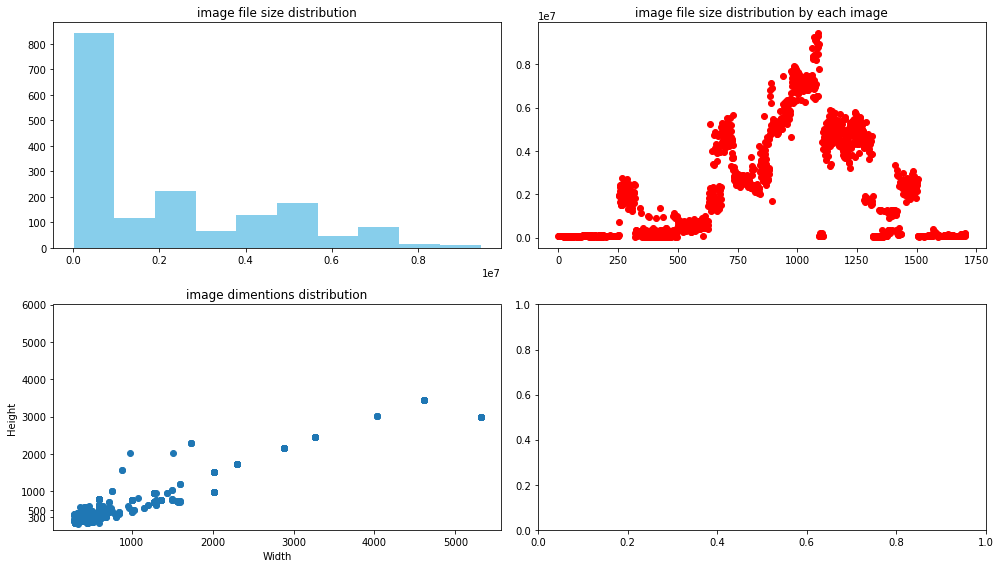

In [0]:
fig, ax = plt.subplots(2, 2 , figsize=[14, 8])

ax[0,0].hist(df_source_images.filesize, color="skyblue")
ax[0,0].set_title('image file size distribution')

ax[0,1].plot(df_source_images.filesize, 'ro')
ax[0,1].set_title('image file size distribution by each image')

ax[1,0].scatter(df_source_images.width, df_source_images.height)
ax[1,0].set_title('image dimentions distribution')
ax[1,0].set_xlabel('Width')
ax[1,0].set_ylabel('Height')
ax[1,0].set_yticks([300, 500, 1000, 2000, 3000, 4000, 5000, 6000])

plt.tight_layout()
plt.show()

Notice that there are files with large size (over 1MB), we will need to reduce the size of these files.

### Image resizing

In [31]:
preprocess_images(data_source, data_cleaned_source, verbose=1)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_007.jpeg
current size: (600, 800)
new size: (500, 375)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_010.jpeg
current size: (600, 800)
new size: (500, 375)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_019.jpeg
current size: (600, 800)
new size: (500, 375)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_002.jpeg
current size: (600, 800)
new size: (500, 375)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_018.jpeg
current size: (600, 800)
new size: (500, 375)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/5000/5000_020.jpeg
current size: 

OSError: ignored

### Train - Validation splitting

In [0]:
train_val_split(verbose=1, train_size=0.8)

### Plot some preprocessed images

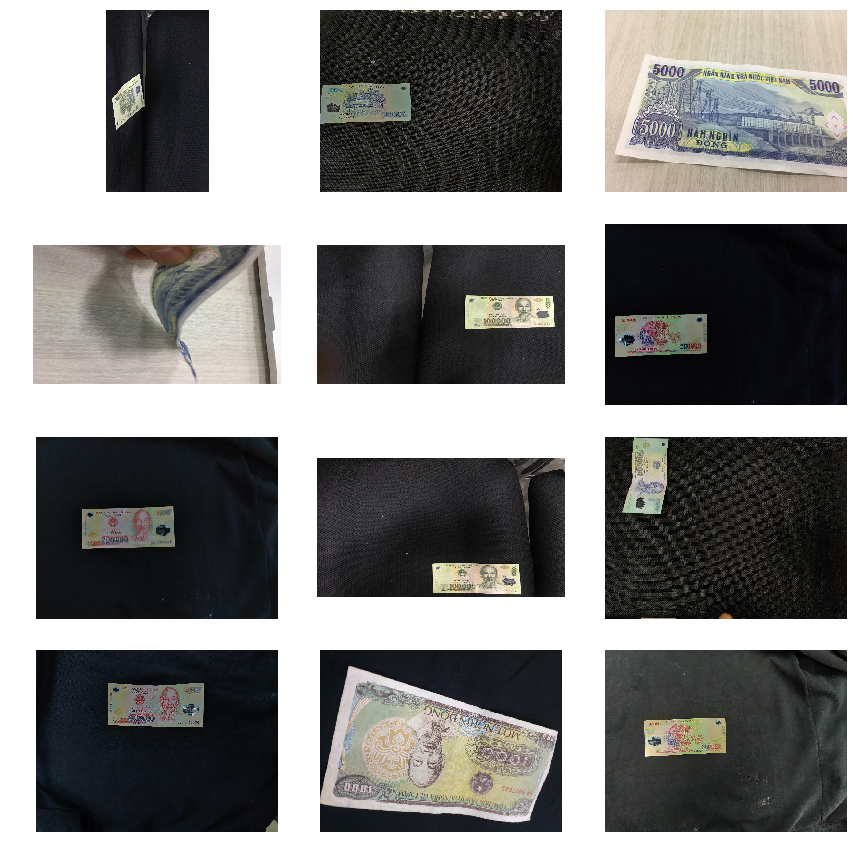

In [0]:
all_preprocessed_images = [str(x) for x in data_train_path.glob('*/*') if x.parent.name in label_names]

random.shuffle(all_preprocessed_images)

image_list = []
for image_path in all_preprocessed_images[:12]:
  image = Image.open(image_path)
  image_list.append(image)

plotImages(image_list)

## Create model

In [25]:
# print out all total number of images each label
total_train_images = 0
total_val_images = 0

for label in labels:
  label_train_path = pathlib.Path(os.path.join(data_train_path, label))
  label_val_path = pathlib.Path(os.path.join(data_val_path, label))
  label_train_images = [image for image in label_train_path.glob('*') if image.is_file()]
  label_val_images = [image for image in label_val_path.glob('*') if image.is_file()]
  total_train_images += len(label_train_images)
  total_val_images += len(label_val_images)
  print('total train images in ' + label + ':', len(label_train_images))
  print('total validation images in ' + label + ':', len(label_val_images))
  
print('total train images:', total_train_images)
print('total validation images:', total_val_images)

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rescale=1./255,
#                                         rescale=1./255,
#                                           rotation_range=45,
#                                           brightness_range=(1.1, 1.4),
#                                           shear_range=0.1,
#                                           zoom_range=0.2,
#                                           horizontal_flip=True,
#                                           vertical_flip=True
                                      )

train_generator = train_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=data_train_path,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=data_val_path,
                                                              target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              class_mode='binary')

total train images in 5000: 202
total validation images in 5000: 51
total train images in 1000: 4
total validation images in 1000: 2
total train images in 2000: 140
total validation images in 2000: 36
total train images in 200000: 162
total validation images in 200000: 41
total train images in 500000: 165
total validation images in 500000: 42
total train images in 100000: 160
total validation images in 100000: 40
total train images in 20000: 148
total validation images in 20000: 37
total train images in 10000: 131
total validation images in 10000: 33
total train images in 50000: 175
total validation images in 50000: 44
total train images: 1287
total validation images: 326
Found 1287 images belonging to 9 classes.
Found 326 images belonging to 9 classes.


## Plot augmented images

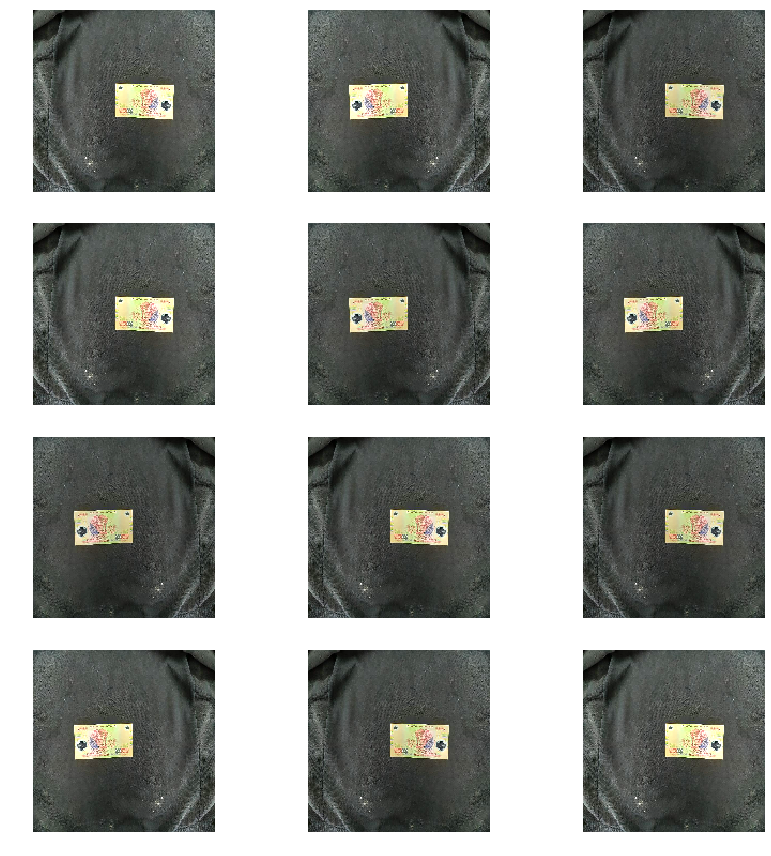

In [0]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D

def create_model():
  
  model = tf.keras.Sequential()
  
  model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
#   model.add(GlobalAveragePooling2D()),
  model.add(Dense(len(label_names), activation='softmax')) 
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#   model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

  return model

model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 85, 85, 8)         224       
_________________________________________________________________
batch_normalization_33 (Batc (None, 85, 85, 8)         32        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 42, 42, 8)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 42, 42, 16)        1168      
_________________________________________________________________
batch_normalization_34 (Batc (None, 42, 42, 16)        64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 21, 21, 16)       

In [0]:
def create_model():
  mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False)
  mobile_net.trainable=False

  model = tf.keras.Sequential([
      mobile_net,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model

model = create_model()
model.summary()

## Train Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model.h5', verbose=1, save_best_only=True)
]

In [0]:
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

## Visualize training results

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [0]:
Save the entire model to a HDF5 file
model.save('static/models/my_model.h5')